In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import geopandas as gpd
import itertools
from tqdm import tqdm

In [2]:
hucs = gpd.read_file(r'J:\Geology\WSGS\Projects\Critical Minerals\hotspot analysis\arcgis_blows.shp')
hucs = hucs.to_crs(crs={'init': 'epsg:3732'})

In [3]:
hucs['FID'] = hucs.index.values
#hucs.to_file(driver='ESRI Shapefile', filename='huc_12_fids.shp')

In [4]:
keys = hucs.loc[0:].FID #huc basin number

In [5]:
ds=[]
for i in range(len(hucs)):
    downstream = hucs[hucs['HUC_12'] == hucs.loc[i].HU_12_DS].FID.values
    ds.append(downstream)
#huc basin downstream of huc basin

In [6]:
us = []
for i in range(len(hucs)):
    upstream = hucs.loc[hucs['HU_12_DS'] == hucs.loc[i].HUC_12].FID.values
    us.append(upstream)

In [7]:
lso = []
for i in range(len(ds)):
    ls = []
    if ds[i].size>0:
        ls.append(ds[i][0])
    else:
        ls.append(0)
    for j in range(len(us[i])):
        if us[i].size>0:
            ls.append(us[i][j])
        else:
            ls.append(0)
    lso.append(ls)

In [8]:
neighbors = dict(zip(keys, lso))

In [11]:
def GangsterRoll(element):
    Xbar = hucs[element].mean() #calculates the mean value of the element across all HUCS
    S = np.sqrt((((hucs[element])**2).sum()/len(hucs))-(Xbar**2)) #calculates the S value in the denominator
    import scipy.sparse as sp #import bruh
    mat = sp.dok_matrix((len(hucs), len(hucs)), dtype=np.int8) #creates a sparse matrix based on a dictionary of keys from above
    for huc_a, huc_b in neighbors.items(): #this creates a sparse matrix of spatial contiguity weights
        mat[huc_a, huc_b] = 1
        mat = mat.transpose().tocsr()
    z_score = []
    for i in tqdm(range(len(hucs))): #here is the G* function that calculates the z-score
        try:
            numerator = ((hucs[element].values*mat.toarray()[i]).sum())-(mat.toarray()[i].sum()*Xbar) #numerator
            denominator = np.sqrt(abs((mat.toarray()[i].sum())-(mat.toarray()[i].sum())**2)/(len(mat.toarray()[i])-1))*S #denominator
            z_score.append(numerator/denominator)
        except:
            z_score.append(np.nan)
    hucs['z_score'] = z_score
    hucs['z_score'].replace([np.inf, -np.inf], np.nan, inplace=True)
    hucs['z_score'].fillna(0, inplace=True)
    G = hucs[[element, 'HUC_12', 'z_score', 'geometry']]
    G.to_file(driver='ESRI Shapefile', filename='./drainage hotspots/'+str(element)+'_hotspots.shp')

In [ ]:
element_list = hucs.columns[3:-30].values
for thing in element_list:
    GangsterRoll(thing)

C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\sparse\compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)
  0%|                                                                                         | 0/2175 [00:00<?, ?it/s]C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
  0%|▎                                                                                | 7/2175 [00:00<00:34, 63.64it/s]C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
 79%|█████████████████████████████████████████████████████████████▋                | 1720/2175 [00:32<00:08, 52.67it/s]

In [122]:
import scipy.sparse as sp
mat = sp.dok_matrix((len(hucs), len(hucs)), dtype=np.int8)

In [123]:
for user_id, movie_ids in neighbors.items():
    mat[user_id, movie_ids] = 1

In [124]:
mat = mat.transpose().tocsr()
mat.shape

(2175, 2175)

In [126]:
z_score = []
for i in tqdm(range(len(hucs))):
    try:
        numerator = ((hucs.cu_ppm.values*mat.toarray()[i]).sum())-(mat.toarray()[i].sum()*Xbar) #numerator
        denominator = np.sqrt(abs((mat.toarray()[i].sum())-(mat.toarray()[i].sum())**2)/(len(mat.toarray()[i])-1))*S #denominator
        z_score.append(numerator/denominator)
    except:
        z_score.append(np.nan)
        

  0%|▎                                                                                | 7/2175 [00:00<00:32, 67.29it/s]C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
100%|██████████████████████████████████████████████████████████████████████████████| 2175/2175 [00:33<00:00, 64.84it/s]


In [127]:
hucs['z_score'] = z_score
hucs['z_score'].replace([np.inf, -np.inf], np.nan, inplace=True)
hucs['z_score'].fillna(0, inplace=True)

In [128]:
hucs.z_score.max()

862.9646812747208

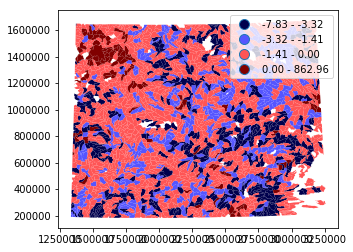

In [129]:
hucs.plot(column='z_score', cmap='seismic', scheme='quantiles', legend=True)


In [130]:
hucs.to_file(driver='ESRI Shapefile', filename='cu_ppm_hotspots.shp')